# Image (.hdr, .mhd, etc...) manipulation for GATE

## Contents:
* Reading images with NumPy
* Reading images with SimpleITK
* Merging images
* Converting Dicom image serie to MetaImages (.mhd/.raw)

# Reading images

## Reading any binary image
PET mouse data from https://neuroimage.usc.edu/neuro/Digimouse_Download in Analyze (.hdr / .img) format.

In [1]:
import numpy as np

file = 'data/mouse_PET.img'
data_type = np.float32
dimension = [128, 128, 129]

# read the binary file
image = np.fromfile(file, dtype=data_type)
image = image.reshape(dimension,order='F')

print('image.min() =', image.min())
print('image.max() =', image.max())
print('image.shape :', image.shape)

image.min() = 0.0
image.max() = 14335.713
image.shape : (128, 128, 129)


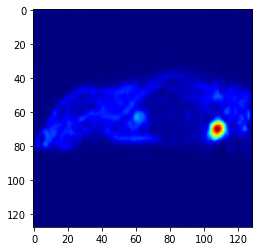

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(image[63,:,:], cmap=plt.cm.jet)

In [3]:
from ipywidgets import interact

def im_viewer(im,cmap):
    def plot_image(myslice):
        plt.imshow(im[myslice,:,:], cmap=cmap)
    interact(plot_image, myslice=(0, im.shape[0]-1))
    return;

im_viewer(image, plt.cm.jet)

interactive(children=(IntSlider(value=63, description='myslice', max=127), Output()), _dom_classes=('widget-in…

In [4]:
# save the binary image
image.tofile('output/mouse_PET_modified.img')

## Reading Meta images (.mhd / .raw)
Easy image reading with the library SimpleITK

In [5]:
import SimpleITK as sitk

# 1) Read the image
itkimage = sitk.ReadImage('data/patient_CT.mhd')
image = sitk.GetArrayFromImage(itkimage)

print ('itkimage.GetSize() :' , itkimage.GetSize())
print ('itkimage.GetSpacing() :' , itkimage.GetSpacing())

print('image.sum() =', image.sum())
print('image.min() =', image.min())
print('image.max() =', image.max())
print('image.shape :', image.shape)

itkimage.GetSize() : (110, 110, 220)
itkimage.GetSpacing() : (4.42, 4.42, 4.42)
image.sum() = -2034006156
image.min() = -1024
image.max() = 3052
image.shape : (220, 110, 110)


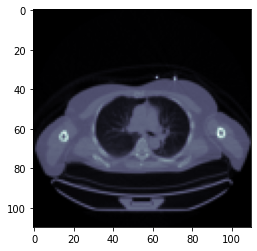

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(image[140,:,:], cmap=plt.cm.bone)

In [8]:
# save the image
output = sitk.GetImageFromArray(image)
sitk.WriteImage(output,'output/patient_CT.mhd')

In [9]:
cat output/patient_CT.mhd

ObjectType = Image
NDims = 3
BinaryData = True
BinaryDataByteOrderMSB = False
CompressedData = False
TransformMatrix = 1 0 0 0 1 0 0 0 1
Offset = 0 0 0
CenterOfRotation = 0 0 0
AnatomicalOrientation = RAI
ElementSpacing = 1 1 1
DimSize = 110 110 220
ElementType = MET_SHORT
ElementDataFile = patient_CT.raw


## Exercise
* modify the image data so that the slices of the CT (220) correspond to the last dimension  
So from (220, 110, 110) to (110, 110, 220)
* crop the image in the Y (2nd) dimension to 25:110
* save the modified image

In [10]:
# complete here ...

## Solution

In [18]:
# we can use the method transpose to change the axis
new_image = image.transpose(1, 2, 0)
print(new_image.shape)

(110, 110, 220)


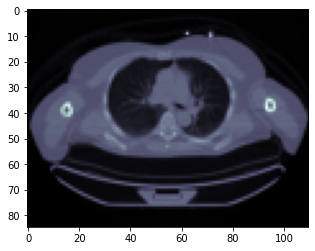

In [19]:
new_image = new_image[25:,:,:]
plt.imshow(new_image[:,:,140], cmap=plt.cm.bone)

In [20]:
# save the new image
output = sitk.GetImageFromArray(new_image)
sitk.WriteImage(output,'output/patient_CT_croped.mhd')

## Reading Dicom images (.dcm)
Easy image reading with the library SimpleITK

In [21]:
import SimpleITK as sitk

# 1) Read the image
itkimage = sitk.ReadImage('data/patient_SPECT.dcm')
image = sitk.GetArrayFromImage(itkimage)

print ('itkimage.GetSpacing() :' , itkimage.GetSpacing())
print('image.sum() =', image.sum())
print('image.min() =', image.min())
print('image.max() =', image.max())
print('image.shape :', image.shape)

itkimage.GetSpacing() : (4.7951998710632, 4.7951998710632, 1.0)
image.sum() = 18169297
image.min() = 0
image.max() = 689
image.shape : (320, 128, 128)


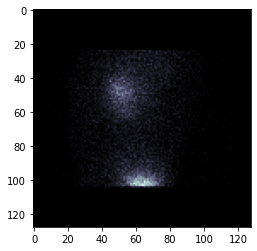

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(image[140,:,:], cmap=plt.cm.bone)

## Reading Dicom images (.dcm)
Easy image reading with the library PyDicom

In [23]:
import pydicom as dcm

# open dicom file (works for all .dcm file)
File = dcm.read_file('data/patient_SPECT.dcm')
# Acces to image pixel data 
image = File.pixel_array

print(type(image))
print('Pixel spacing :', File.PixelSpacing)
print('image.sum() =', image.sum())
print('image.min() =', image.min())
print('image.max() =', image.max())
print('image.shape :', image.shape)

<class 'numpy.ndarray'>
Pixel spacing : [4.7951998710632, 4.7951998710632]
image.sum() = 18169297
image.min() = 0
image.max() = 689
image.shape : (320, 128, 128)


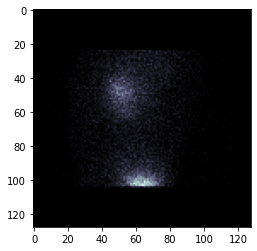

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(image[140,:,:], cmap=plt.cm.bone)

# Merging images

## Merge GATE output DoseActor .mhd of splitted simulations

In [ ]:
import SimpleITK as sitk
from glob import glob

# directory of your simulation splitted outputs
output_dir = 'output/'

# loop over the .mhd outputs
first_image = True
for file in glob(output_dir+'*Dose.mhd'):
#    if '_merged' not in file:
        print ('Reading file:',file)
        # 1) Read the image
        itkimage = sitk.ReadImage(file)
        # 2) Sum the image values
        if first_image:
            image_merged = sitk.GetArrayFromImage(itkimage)
            first_image = False
        else: 
            image_merged += sitk.GetArrayFromImage(itkimage)
        #print ('Sum of all voxels:',image_merged.max())

# 3) Write the sum of all images
itkimage_merged = sitk.GetImageFromArray(image_merged)
itkimage_merged.CopyInformation(itkimage)
sitk.WriteImage(itkimage_merged, output_dir+'output-Dose_merged.mhd')

print ('Merged file created:', output_dir+'output-Dose_merged.mhd')
print ('Dimension : ' , itkimage_merged.GetSize())
print ('Pixels Size :' , itkimage_merged.GetSpacing())

# Converting DICOM to MetaImage (.mhd/.raw)

In [ ]:
import SimpleITK as sitk

input_dir = 'convert/dicom/'
output_dir = 'convert/mhd/'

series_IDs = sitk.ImageSeriesReader_GetGDCMSeriesIDs(input_dir)

if not series_IDs:
    print('No series in directory ' + input_dir)

for series in series_IDs:
    filename = series.split('.')[-1]
    sitk.WriteImage(sitk.ReadImage(sitk.ImageSeriesReader_GetGDCMSeriesFileNames(input_dir, series)),
                    output_dir+filename+'.mhd')
    print('Dicom serie converted to:', output_dir+filename+'.mhd')

## Exercise
* place a copy of the data/patient_CT_dcm/*.dcm images in the folder convert/dicom/  
* convert the Dicom images serie to a single .mhd image using the cell above
* read the converted image and display an axial slice of it

In [27]:
# complete here ...

## Solution

In [28]:
!cp data/patient_CT_dcm/*.dcm convert/dicom/
!ls convert/dicom/

image-000000.dcm  image-000007.dcm  image-000014.dcm  image-000021.dcm
image-000001.dcm  image-000008.dcm  image-000015.dcm  image-000022.dcm
image-000002.dcm  image-000009.dcm  image-000016.dcm  image-000023.dcm
image-000003.dcm  image-000010.dcm  image-000017.dcm  image-000024.dcm
image-000004.dcm  image-000011.dcm  image-000018.dcm  image-000025.dcm
image-000005.dcm  image-000012.dcm  image-000019.dcm
image-000006.dcm  image-000013.dcm  image-000020.dcm


In [29]:
import SimpleITK as sitk

input_dir = 'convert/dicom/'
output_dir = 'convert/mhd/'

series_IDs = sitk.ImageSeriesReader_GetGDCMSeriesIDs(input_dir)

if not series_IDs:
    print('No series in directory ' + input_dir)

for series in series_IDs:
    filename = series.split('.')[-1]
    sitk.WriteImage(sitk.ReadImage(sitk.ImageSeriesReader_GetGDCMSeriesFileNames(input_dir, series)),
                    output_dir+filename+'.mhd')
    print('Dicom serie converted to:', output_dir+filename+'.mhd')
    
!ls convert/mhd/

Dicom serie converted to: convert/mhd/07877442.mhd
07877442.mhd  07877442.raw


In [30]:
import SimpleITK as sitk

# 1) Read the image
itkimage = sitk.ReadImage('convert/mhd/07877442.mhd')
image = sitk.GetArrayFromImage(itkimage)

print('image.shape :', image.shape)

image.shape : (26, 512, 512)


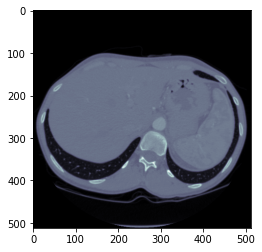

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(image[20,:,:], cmap=plt.cm.bone)